<h1>Содержание проекта<span class="tocSkip"></span></h1>

1  Исследовательский анализ данных

    1.1  Просмотр данных
    1.2  Анализ данных
    1.3  Просмотр файлов
    1.4  Общий вывод

2  Обучение модели

    2.1  Код обучения модели
    2.2  Результат вывода обучения

3  Анализ обученной модели

4  Общий вывод

# Определение возраста покупателей

**Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.**

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

В вашем распоряжении набор фотографий людей с указанием возраста.

# Цели и задачи проекта

**Цель проекта:** Постройте модель, которая по фотографии определит приблизительный возраст человека.

**Условия задачи:**
- Постройте модель со значением метрики качества *MAE* на тестовой выборке не больше 8.

**Дополнительная информация:**

1. Функцией потерь не обязательно должна быть MAE. Зачастую нейронные сети с функцией потерь MSE обучаются быстрее.
2. Качество на валидационной выборке улучшается, но модель при этом переобучается всё сильнее? Не спешите менять модель. Обычно нейронные сети с большим числом слоёв сильно переобучаются.
3. В [статье о датасете](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf), с которым вы работаете, значение MAE равно 5.4 — если вы получите MAE меньше 7, это будет отличный результат!


**План выполнения работ:**

1. Провести исследовательский анализ данных
2. Обучить модель
3. Сделать анализ модели
4. Сделать выводы


## Исследовательский анализ данных

**Цель анализа:** Сделайте выводы о том, как результаты исследования повлияют на обучение модели. 

**Инструкция по выполнению:**

1. Посмотрите на размер выборки.
2. Постройте график распределения возраста в выборке.
3. Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.


**Описание данных:**

Данные находятся в папке `/datasets/faces/`. В вашем распоряжении одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`. 

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.image import imread

import seaborn as sns
sns.set(rc={'figure.figsize':(16,6)})
sns.set_palette('dark:#5A9_r')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Просмотр данных

In [3]:
# загрузим файл
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
# посмотрим информацию
display(labels.head())
display(labels.tail())
display(labels.info())
print('-'*50)
print('Describe:')
display(labels.describe())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

--------------------------------------------------
Describe:


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Да, действительно `labels.csv` с двумя колонками: `file_name` и `real_age`,<br/>
При этом видим, что максимальный возраст 100 лет (допускаю), минимальный 1 год (ребенок, допустимо в принципе).

На всякий случай, посмотрим на дубликаты и пропуски:

In [5]:
print()
print('Полных дубликатов:', sum(labels.duplicated()))
print()
print('Пропуски:')
display(labels.isna().sum())


Полных дубликатов: 0

Пропуски:


file_name    0
real_age     0
dtype: int64

**Вывод:** на данном этапе ничего критичного, переходим к анализу.

###  Анализ данных

Построим график распределения возраста в выборке

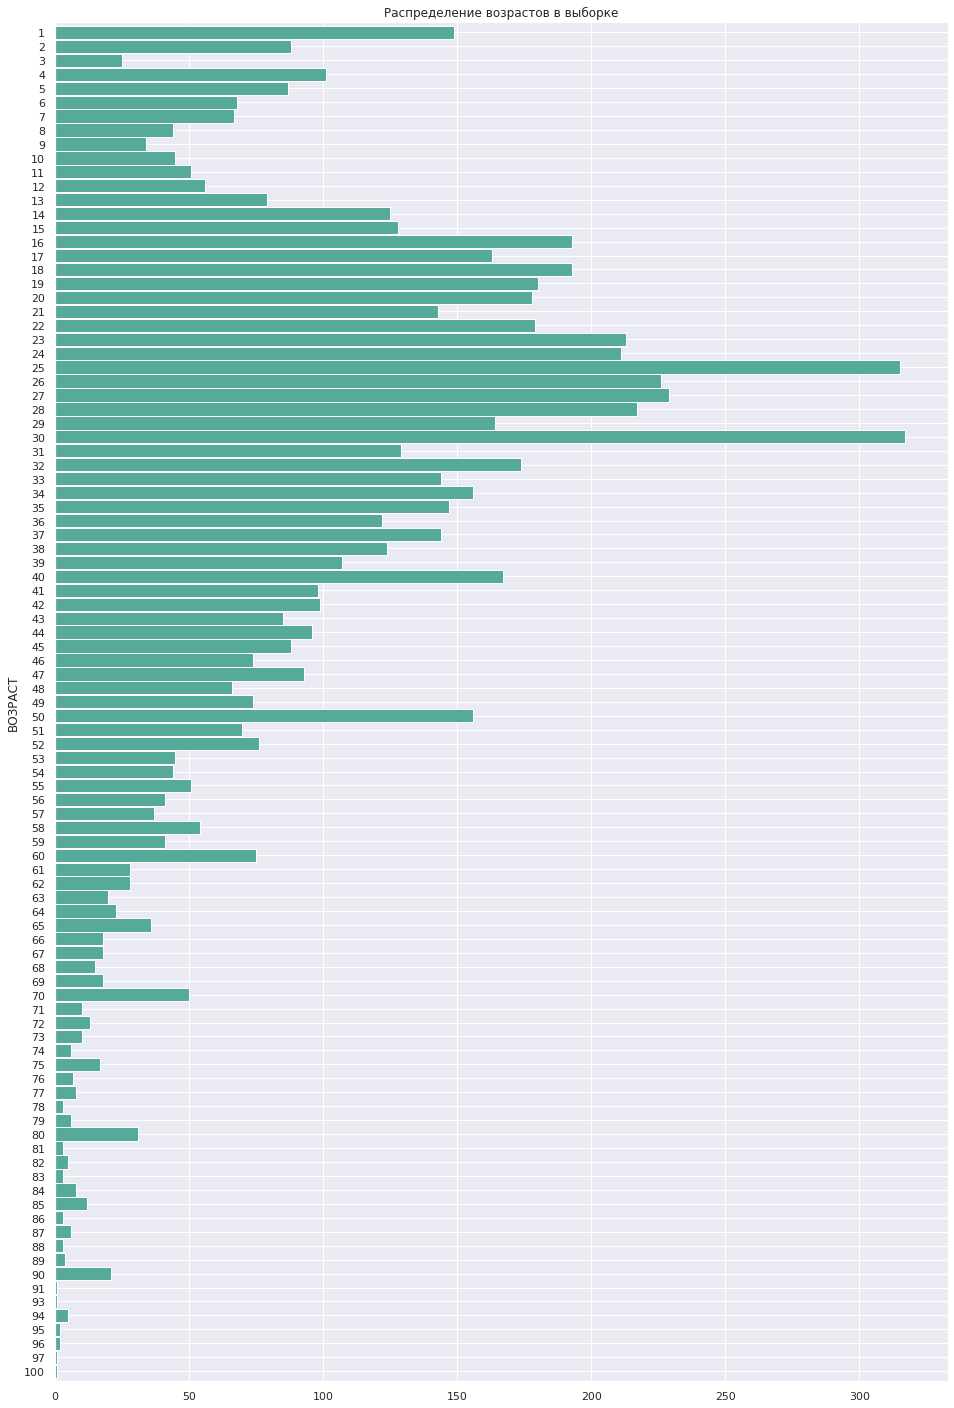

In [6]:
labels['real_age'].value_counts().sort_index(ascending=False).plot(figsize=(16,25),
    kind='barh', rot=0, ylabel='ВОЗРАСТ', title='Распределение возрастов в выборке', width=.95);
plt.show();

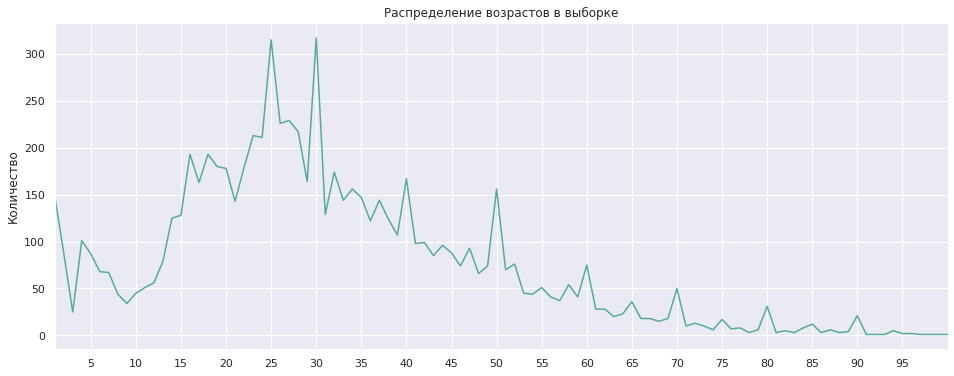

In [7]:
labels['real_age'].value_counts().sort_index(ascending=False).plot(
    xticks=range(0,max(labels['real_age']),5),xlim=(1,max(labels['real_age'])),
    kind='line', rot=0, ylabel='Количество', title='Распределение возрастов в выборке');
plt.show();

**Вывод:** Возраст распределен в целом нормально, в основном это люди 13-50 лет, и дети. Присутствуют и старики.<br/>Аномальных выбросов не замечено.

###  Просмотр файлов
**Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.**

Посмотрим с какими файлами нам предстоит работать.

In [8]:
# прочитаем файлы
directory = '/datasets/faces/final_files/'
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345) 
#features, target = next(train_gen_flow)

Found 7591 validated image filenames.


In [8]:
len(labels)

7591

Видим что количество изображений соответствует количеству записей labels.

**И, наконец, проверим, с чем предстоит работать:**

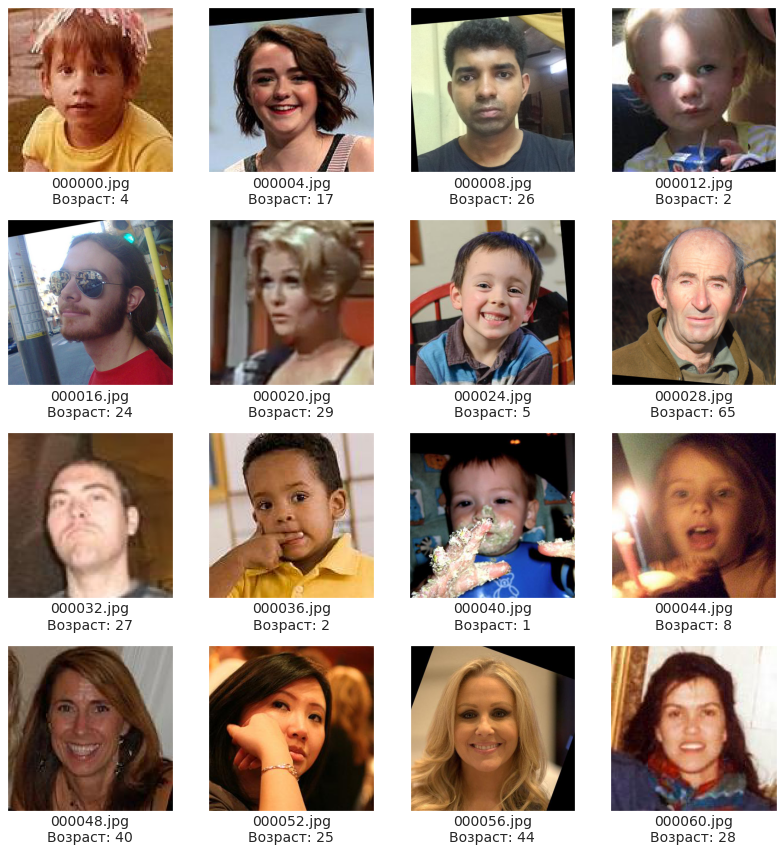

In [9]:
# возьмем каждую четвертую фотографию для разнообразия
fig = plt.figure(figsize=(12,12));subplot_i=0;
for i in range(0,64,4):
    image = imread(directory+labels['file_name'][i])    
    fig.add_subplot(4,4,subplot_i+1)
    plt.imshow(image)
    plt.xticks([]);plt.yticks([]);
    plt.xlabel(labels['file_name'][i]+'\nВозраст: '+str(labels['real_age'][i]),fontsize=14)
    plt.tight_layout();subplot_i+=1;

**Вывод:** на картинках crop лица людей, с разными фонами, возраст судя по всему соответствует.

### Общий вывод

**Цель анализа:** Сделайте выводы о том, как результаты исследования повлияют на обучение модели. 

**Выполнены задачи:**

1. Посмотрите на размер выборки.
2. Постройте график распределения возраста в выборке.
3. Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.

**ВЫВОДЫ:**
- датасет содержит 7591 запись без дубликатов и пропусков
- в папке находится соответствующе 7591 изображений
- не все изображения корректно размечены по возрасту, это может негативно повлиять на обучение модели.

## Обучение модели

### Код обучения модели

```python
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

def load_train(path):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path+'labels.csv'),
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path+'labels.csv'),
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow


def create_model(input_shape):    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 
    
    model = Sequential()    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=12,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

### Результат вывода обучения

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/12
178/178 - 53s - loss: 238.5467 - mae: 11.0138 - val_loss: 567.9721 - val_mae: 18.7908
Epoch 2/12
178/178 - 44s - loss: 70.2006 - mae: 6.3327 - val_loss: 635.0816 - val_mae: 20.0836
Epoch 3/12
178/178 - 44s - loss: 45.6533 - mae: 5.1754 - val_loss: 336.5440 - val_mae: 13.6026
Epoch 4/12
178/178 - 43s - loss: 33.5987 - mae: 4.4056 - val_loss: 109.6879 - val_mae: 7.9161
Epoch 5/12
178/178 - 44s - loss: 24.4458 - mae: 3.7219 - val_loss: 76.7667 - val_mae: 6.6423
Epoch 6/12
178/178 - 44s - loss: 17.5257 - mae: 3.1867 - val_loss: 66.5719 - val_mae: 6.0690
Epoch 7/12
178/178 - 40s - loss: 13.1847 - mae: 2.7530 - val_loss: 71.2380 - val_mae: 6.4714
Epoch 8/12
178/178 - 40s - loss: 11.4201 - mae: 2.5448 - val_loss: 71.3223 - val_mae: 6.2282
Epoch 9/12
178/178 - 40s - loss: 10.5173 - mae: 2.4198 - val_loss: 62.6155 - val_mae: 5.8875
Epoch 10/12
178/178 - 39s - loss: 9.9952 - mae: 2.3028 - val_loss: 62.3597 - val_mae: 5.8574
Epoch 11/12
178/178 - 41s - loss: 9.0105 - mae: 2.2045 - val_loss: 62.9968 - val_mae: 5.9005
Epoch 12/12
178/178 - 40s - loss: 7.8437 - mae: 2.0967 - val_loss: 60.8404 - val_mae: 5.7973
60/60 - 10s - loss: 60.8404 - mae: 5.7973
Test MAE: 5.7973
```

**Вывод:** Test MAE: 5.7973 меньше 8, что соответствует условию задачи.

## Анализ обученной модели

In [11]:
df_data = [[18.7908],[18.7908],[20.0836],[13.6026],[7.9161],[6.6423],[6.0690],
           [6.4714],[6.2282],[5.8875],[5.8574],[5.9005],[5.7973]]
df = pd.DataFrame(df_data, columns=['MAE'])

**Информация об обучении:**

- При обучении использовали батчи по 32 картинки размером 224х224 с тремя каналами (shape 224 224 3).

- Сделали rescale=1./255 чтобы получить значения в диапазоне 0-1.

- Добавили аугментацию отражения картинки по горизонтали horizontal_flip=True.

- Оптимизатором выбрали Adam с learning_rate=0.0001.

- Функция потерь: mean_squared_error, Метрика: MAE (по условию задачи).

- Размер валидационной выборки 25% от train.


**Информация о модели:**

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0
_________________________________________________________________
dense (Dense)                (None, 256)               524544
_________________________________________________________________
dense_1 (Dense)              (None, 80)                20560
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81
=================================================================
Total params: 24,132,897
Trainable params: 24,079,777
Non-trainable params: 53,120
_________________________________________________________________
```

- Применили архитектуру ResNet50
- Добавили пулинг GlobalAveragePooling2D с окном во весь тензор
- Добавили полносвязный (Dense) слой для классификации с 256 выходами
- Добавили полносвязный (Dense) слой для классификации с 80 выходами
- Добавили полносвязный (Dense) слой для классификации с 1 выходом (цифра=возраст)


---------

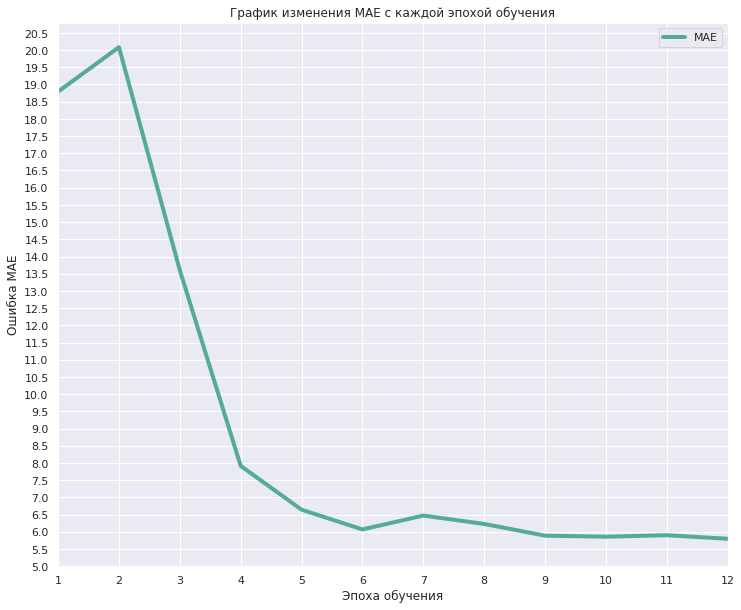

In [12]:
df.plot(
    xticks=range(1,len(df_data)),xlim=(1,len(df_data)-1),lw=4,yticks=np.arange(5,21,.5),figsize=(12,10),
    kind='line', rot=0, ylabel='Ошибка MAE', xlabel='Эпоха обучения', title='График изменения MAE с каждой эпохой обучения');
plt.show();

Если просуммировать цифры из вывода в GPU-тренажёре, то получается:

- Время обучения 12 эпох составило: **9 минут 12 секунд**

- Прогноз TEST занял: **10 секунд**.

**Вывод:** MAE: 5.7973 модели соответствует условиям задачи.

## Общий вывод

**Цель проекта:** Постройте модель, которая по фотографии определит приблизительный возраст человека.

**Выполнены работы:**

1. Провести исследовательский анализ данных

    1.1. Посмотрите на размер выборки.
    
    1.2. Постройте график распределения возраста в выборке.
    
    1.3. Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.
    

2. Обучить модель

    2.1. Вывести код обучения модели
    
    2.2. Вывести результаты обучения модели
    

3. Сделать анализ модели

    3.1. Время обучения 12 эпох составило: 9 минут 12 секунд<br/>
    Прогноз TEST занял: 10 секунд.
        
    3.2. MAE: 5.7973 на тестовой выборке.


4. Сделать выводы

**Решены задачи:**
- Постройте модель со значением метрики качества *MAE* на тестовой выборке не больше 8.
- - **Построена модель с MAE 5.7973 на тестовой выборке.**